## Example for computing parallel imaging g-factor using BART Python interface

Author: Jon Tamir <jtamir@eecs.berkeley.edu>

In [1]:
import numpy as np
from scipy.io import loadmat
import h5py
import time

import cfl
from bart import bart

import matplotlib.pyplot as plt
%matplotlib inline

from pylab import rcParams
rcParams['figure.figsize'] = 7, 7

## Create multi-channel phantom in k-space

In [2]:
nx = 128
ny = 128
nc = 8

rx = 1
ry = 4

n_mc = 30


In [3]:
!bart phantom -h

Usage: phantom [-s d] [-S d] [-k] [-t <string>] [-x d] [-3] <output>

Image and k-space domain phantoms.

-s nc      	nc sensitivities
-S Output nc sensitivities
-k		k-space
-t file      	trajectory
-x n      	dimensions in y and z
-3		3D
-h		help


In [4]:
ksp = bart(1, 'phantom -x 128 -s 8 -k').squeeze()

In [5]:
path = '/home/jamalzada/Downloads/raw_data.mat'
data = read_matlab(path)
kspw = data['raw'].squeeze()
sdata = loadmat('sref.mat')
g=sdata['s_ref']
raw = ksp['real']+1j*ksp['imag']


NameError: name 'read_matlab' is not defined

In [344]:
k3d = bart(1,'phantom -x 128 -s 8 -k -3').squeeze()

Exception: Command exited with an error.

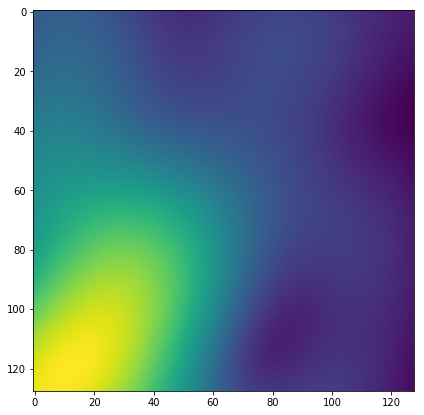

In [328]:
plt.imshow(abs(k3d[:,:,100,4]))


In [339]:
cimg = bart(1,'fft -iu 7',k3d)


In [340]:
fft = np.fft.ifftn(k3d,axes=(0,1,2))


In [341]:
fftsh = np.fft.fftshift(fft,axes=(0,1,2))

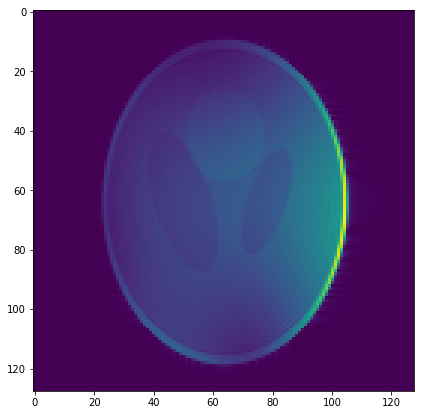

In [342]:
plt.imshow(abs(fftsh[:,:,85,7]))

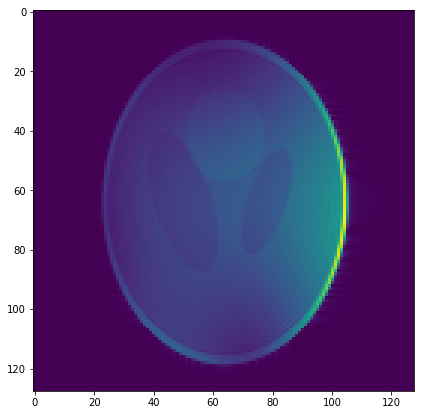

In [343]:
plt.imshow(abs(cimg[:,:,85,7]))

In [345]:
k3d=np.load('phantom3d_kspace.npy')

In [261]:
k3dd=np.copy(k3d[:,:,:,:])
k3dd.shape

(128, 128, 128, 8)

In [132]:
nc=8

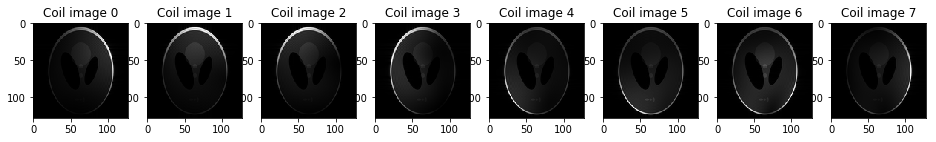

In [149]:
ksp = bart(1, 'phantom -x {} -s {} -k'.format(nx, nc)).squeeze()
cimg = bart(1, 'fft -iu 3', ksp)

plt.figure(figsize=(16,20))
for i in range(nc):
    plt.subplot(1, nc, i+1)
    plt.imshow(abs(cimg[:,:,i]).squeeze(), cmap='gray')
    plt.title('Coil image {}'.format(i))

## Estimate coil sensitivities

In [8]:
!bart ecalib -h

Usage: ecalib [-t f] [-c f] [-k ...] [-r ...] [-m d] [-S] [-W] [-I] [-1] [-P] [-v f] [-a] <kspace> <sensitivites> [<ev-maps>]

Estimate coil sensitivities using ESPIRiT calibration.
Optionally outputs the eigenvalue maps.

-t threshold      	This determined the size of the null-space.
-c crop_value      	Crop the sensitivities if the eigenvalue is smaller than {crop_value}.
-k ksize      	kernel size
-r cal_size      	Limits the size of the calibration region.
-m maps      	Number of maps to compute.
-S		create maps with smooth transitions (Soft-SENSE).
-W		soft-weighting of the singular vectors.
-I		intensity correction
-1		perform only first part of the calibration
-P		Do not rotate the phase with respect to the first principal component
-v variance      	Variance of noise in data.
-a		Automatically pick thresholds.
-h		help


In [158]:
nc=8

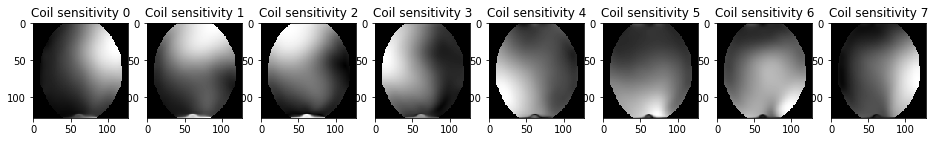

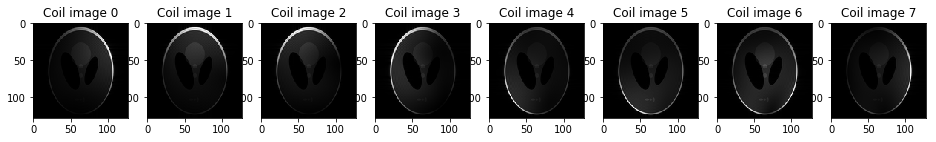

In [159]:
sens = bart(1, 'ecalib -m1', ksp[:,:,None,:]).squeeze()

plt.figure(figsize=(16,20))
for i in range(nc):
    plt.subplot(1, nc, i+1)
    plt.imshow(abs(sens[:,:,i]).squeeze(), cmap='gray')
    plt.title('Coil sensitivity {}'.format(i))
    
plt.figure(figsize=(16,20))
for i in range(nc):
    plt.subplot(1, nc, i+1)
    plt.imshow(abs(cimg[:,:,i]).squeeze(), cmap='gray')
    plt.title('Coil image {}'.format(i))

## Create sampling patterns

In [37]:
def caipi(r,ry,shifts):
    """Generates Caipirinha binary unit cells on sheared grids that form periodic lattices
    
    Parameters:
        r (int): total acceleration factor
        ry (int): acceleration factor in the y-direction
        shifts (list), (numpy array): size of shifts in the z-direction
    
    Returns:
        3D numpy array [shifts, ry, rz] containing the patterns
        
    
    """
    rz = int(r/ry)
    patterns = np.zeros((len(shifts),r,r))
    for i, shift in enumerate(shifts):
        cell = np.zeros((r,r))
        for row in range(rz):
            cell[row*ry,(shift*row+rz)%r::rz]=1
        patterns[i] = np.copy(cell)
    return patterns

In [38]:
def caipi(r,ry,shifts):
    """Generates Caipirinha binary unit cells on sheared grids that form periodic lattices
    
    Parameters:
        r (int): total acceleration factor
        ry (int): acceleration factor in the y-direction
        shifts (list), (numpy array): size of shifts in the z-direction
    
    Returns:
        3D numpy array [shifts, ry, rz] containing the patterns
        
    
    """
    rz = int(r/ry)
    patterns = np.zeros((len(shifts),r,r))
    l = 0
    for i, shift in enumerate(shifts):
        cell = np.zeros((r,r))
        for row in range(rz):
            if (shift*row+rz)>= r:
                l = (shift*row%r+rz)%rz
            else:
                l = shift*row
            cell[row*ry,l::rz]=1
        patterns[i] = np.copy(cell)
    return patterns

In [46]:
shifts=[0,1,2,3,4,5,6,7]
shifts=np.arange(8)
R=8
p=caipi(R,1,shifts)

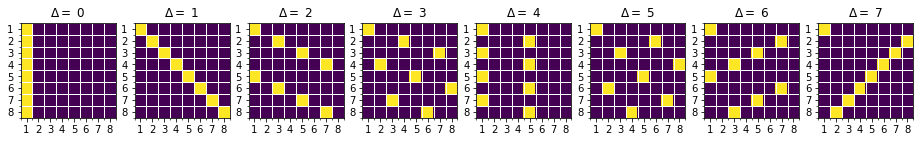

In [43]:
plot_patterns(p,shifts,rows=8)

In [44]:
def plot_patterns(matrix, shifts,rows=8):
    n_patterns = len(matrix)
    R = matrix.shape[1]
    k = int(n_patterns/rows)+((n_patterns%rows)>0)
    s = np.array(shifts)+1
    plt.figure(figsize=(16,8))
    for i in np.arange(n_patterns):
        plt.subplot(k,rows,s[i])
        plt.imshow(matrix[i])
        plt.title('$\Delta=$ {}'.format(shifts[i]))
        ax = plt.gca();

        # Major ticks
        ax.set_xticks(np.arange(0, R, 1));
        ax.set_yticks(np.arange(0, R, 1));

        # Labels for major ticks
        ax.set_xticklabels(np.arange(1, R+1, 1));
        ax.set_yticklabels(np.arange(1, R+1, 1));

        # Minor ticks
        ax.set_xticks(np.arange(-.5, R, 1), minor=True);
        ax.set_yticks(np.arange(-.5, R, 1), minor=True);

        # Gridlines based on minor ticks
        ax.grid(which='minor', color='w', linestyle='-', linewidth=1)


In [67]:
np.kron(np.ones((int(nx/R),int(nx/R))),p[3])

array([[1., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 1., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 1., ..., 0., 0., 0.],
       [0., 0., 0., ..., 1., 0., 0.]])

Text(0.5,1,'CAIPI grid sampling pattern (N=2048.0)')

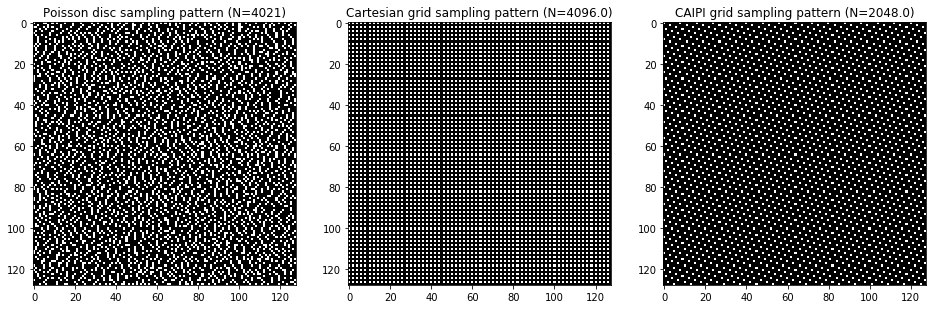

In [69]:
mask_pd = bart(1, 'poisson -Y {} -Z {} -y {} -z {}'.format(nx, ny, rx, ry)).squeeze() != 0
mask_cg = np.zeros((nx, ny))
mask_cg[::2,::2] = 1
mask_ca = np.kron(np.ones((int(nx/R),int(nx/R))),p[3])

plt.figure(figsize=(16, 8))
plt.subplot(1, 3, 1)
plt.imshow(mask_pd, cmap='gray')
plt.title('Poisson disc sampling pattern (N={})'.format(np.sum(mask_pd)))
plt.subplot(1, 3, 2)
plt.imshow(mask_cg, cmap='gray')
plt.title('Cartesian grid sampling pattern (N={})'.format(np.sum(mask_cg)))
plt.subplot(1,3,3)
plt.imshow(mask_ca,cmap='gray')
plt.title('CAIPI grid sampling pattern (N={})'.format(np.sum(mask_ca)))

In [146]:
raw.shape

(16, 96, 96)

## apply masks and reconstruct

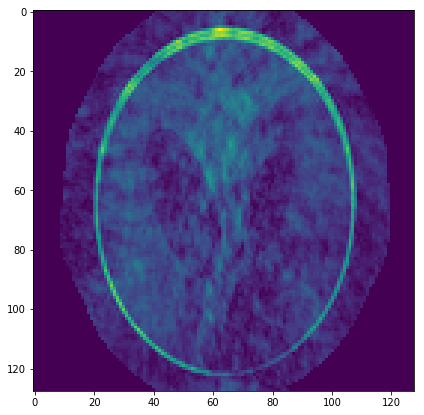

In [72]:
ksp_cg = ksp.copy() * mask_cg[:,:,None]
ksp_pd = ksp.copy() * mask_pd[:,:,None]
ksp_ca=ksp.copy() * mask_ca[:,:,None]
cimg = bart(1, 'fft -iu 3', ksp_pd)
plt.imshow(abs(np.sum(bart(1, 'fft -iu 3', ksp_pd)*np.conj(sens),axis=2)))

In [125]:
ksp = np.copy(raw)
sens = swap(g.squeeze())

In [128]:
g.squeeze().shape

(96, 96, 16)

In [121]:
ksp_cg = ksp.copy() * mask_cg[:,:,None]
ksp_pd = ksp.copy() * mask_pd[:,:,None]
ksp_ca = ksp.copy() * mask_ca[:,:,None]#*y[:,:,None]
reco_pd_zfill = np.sum(bart(1, 'fft -iu 3', ksp_pd) * np.conj(sens), axis=2)
reco_cg_zfill = np.sum(bart(1, 'fft -iu 3', ksp_cg) * np.conj(sens), axis=2)
reco_ca_zfill = np.sum(bart(1, 'fft -iu 3', ksp_ca) * np.conj(sens), axis=2)

plt.figure(figsize=(16, 8))
plt.subplot(1, 3, 1)
plt.imshow(abs(reco_pd_zfill).squeeze(), cmap='gray')
plt.title('Poisson disc zero-filled')

plt.subplot(1, 3, 2)
plt.imshow(abs(reco_cg_zfill).squeeze(), cmap='gray')
plt.title('Cartesian grid zero-filled ')

plt.subplot(1,3,3)
plt.imshow(abs(reco_ca_zfill).squeeze(),cmap='gray')
plt.title('Caipi grid zero-filled')


ValueError: operands could not be broadcast together with shapes (16,96,96) (128,128,1) 

Text(0.5,1,'CAIPI grid noiseless reconstruction')

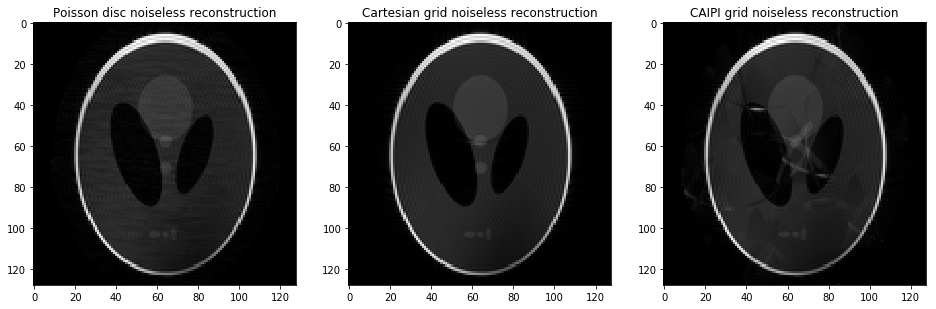

In [75]:
reco_cg_clean = bart(1, 'pics -S -i50', ksp_cg[:,:,None,:], sens[:,:,None,:])
reco_pd_clean = bart(1, 'pics -S -i50', ksp_pd[:,:,None,:], sens[:,:,None,:])
reco_ca_clean = bart(1, 'pics -S -i50', ksp_ca[:,:,None,:], sens[:,:,None,:])

plt.figure(figsize=(16, 8))
plt.subplot(1, 3, 1)
plt.imshow(abs(reco_pd_clean).squeeze(), cmap='gray')
plt.title('Poisson disc noiseless reconstruction')

plt.subplot(1, 3, 2)
plt.imshow(abs(reco_cg_clean).squeeze(), cmap='gray')
plt.title('Cartesian grid noiseless reconstruction')

plt.subplot(1, 3, 3)
plt.imshow(abs(reco_ca_clean).squeeze(), cmap='gray')
plt.title('CAIPI grid noiseless reconstruction')

## repeat reconstruction with N_MC noise instances

In [76]:
recons_cg = np.zeros((nx, ny, n_mc), dtype=np.complex)
recons_pd = np.zeros((nx, ny, n_mc), dtype=np.complex)
recons_ca = np.zeros((nx,ny,n_mc),dtype=np.complex)
tic = time.time()
for i in range(n_mc):

    ksp_noise = np.random.randn(*ksp.shape) + 1j*np.random.randn(*ksp.shape)
    ksp_noise_cg = mask_cg[:,:,None] * (ksp + ksp_noise)
    ksp_noise_pd = mask_pd[:,:,None] * (ksp + ksp_noise)
    ksp_noise_ca = mask_ca[:,:,None] * (ksp + ksp_noise)
    
    recons_cg[:,:,i] = bart(1, 'pics -S -i 50', ksp_noise_cg[:,:,None,:], sens[:,:,None,:])
    recons_pd[:,:,i] = bart(1, 'pics -S -i 50', ksp_noise_pd[:,:,None,:], sens[:,:,None,:])
    recons_ca[:,:,i] = bart(1, 'pics -S -i 50', ksp_noise_ca[:,:,None,:], sens[:,:,None,:])
    
toc = time.time()



print('Done ({} s)'.format(toc - tic))

Done (31.375464916229248 s)


8

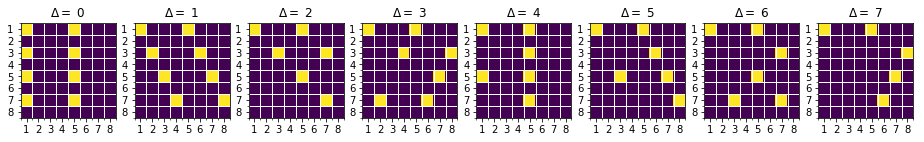

In [666]:
shifts = [0,1,2,3,4,5,6,7]
p = caipi(8,2,shifts)
plot_patterns(p,shifts,rows=8)
len(p)

In [598]:
np.kron(np.ones((2,2)),p[i]).shape

(16, 16)

In [668]:
mask = np.kron(np.ones((size,size)),p[j])


In [604]:
recons_caipi = np.zeros((nx, ny, n_mc,len(p)), dtype=np.complex)

tic = time.time()
for j in range(len(p)):#number of caipi patterns
    size = int(ksp.shape[0]/p.shape[1])
    mask = np.kron(np.ones((size,size)),p[j])
    for i in range(n_mc):

        ksp_noise = np.random.randn(*ksp.shape) + 1j*np.random.randn(*ksp.shape)
        ksp_noise_caipi = mask[:,:,None] * (ksp + ksp_noise)
        recons_caipi[:,:,i,j] = bart(1, 'pics -S -i 50', ksp_noise_caipi[:,:,None,:], sens[:,:,None,:])


toc = time.time()



print('Done ({} s)'.format(toc - tic))

Done (128.5592336654663 s)


In [639]:
recons_noise_caipi = np.zeros((nx, ny, n_mc,len(p)), dtype=np.complex)

tic = time.time()
for j in range(len(p)):
    for i in range(n_mc):

        ksp_noise = np.random.randn(*ksp.shape) + 1j*np.random.randn(*ksp.shape)
        recons_noise_caipi[:,:,i,j] = bart(1, 'pics -S -i 50 ', ksp_noise[:,:,None,:], sens[:,:,None,:])
    
toc = time.time()

print('Done ({} s)'.format(toc - tic))

Done (75.16126132011414 s)


In [609]:
recons_caipi.shape

(128, 128, 30, 8)

In [667]:
recon_noise_std_caipi = np.std(recons_noise_caipi, axis=2)
gfactor_caipi = np.divide(np.std(recons_caipi.real, axis=2), recon_noise_std_caipi, where=abs(recons_caipi[:,:,0,:].squeeze()) != 0)


gfactor_caipi /= np.sqrt(1 * 8)

max_gf_caipi = np.max(gfactor_caipi,axis=(0,1))

for i in range(8):
    print('Max Caipi 1x8^{} g-factor value: {}'.format(i, max_gf_caipi[i]))


Max Caipi 1x8^0 g-factor value: 9.973174842367822
Max Caipi 1x8^1 g-factor value: 8.941723105684344
Max Caipi 1x8^2 g-factor value: 12.090002279223242
Max Caipi 1x8^3 g-factor value: 12.105616064826847
Max Caipi 1x8^4 g-factor value: 11.217965431812623
Max Caipi 1x8^5 g-factor value: 11.248707163559928
Max Caipi 1x8^6 g-factor value: 12.53433258320878
Max Caipi 1x8^7 g-factor value: 8.027232134091788


In [641]:
np.max(gfactor_caipi, axis=(0,1)).shape

(8,)

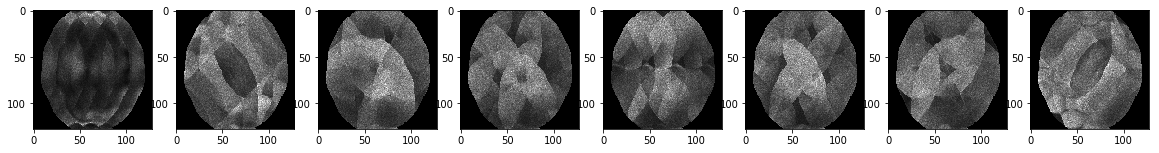

In [679]:
plt.figure(figsize=(20,5))
for i in range(8):
    plt.subplot(1,8,i+1)
    plt.imshow(gfactor_caipi[:,:,i],cmap='gray')

## repeat reconstruction with N_MC noise-only instances

In [643]:
recons_noise = np.zeros((nx, ny, n_mc), dtype=np.complex)

tic = time.time()
for i in range(n_mc):
    
    ksp_noise = np.random.randn(*ksp.shape) + 1j*np.random.randn(*ksp.shape)
    recons_noise[:,:,i] = bart(1, 'pics -S -i 50 ', ksp_noise[:,:,None,:], sens[:,:,None,:])
    
toc = time.time()

print('Done ({} s)'.format(toc - tic))

Done (12.38335633277893 s)


## compute g-factor

'$mu$'

Max Poison disc g-factor value: 3.6814525888847127
Max Cartesian Grid g-factor value: 3.906032938849367
Max CAIPI g-factor value: 3.136861766639574


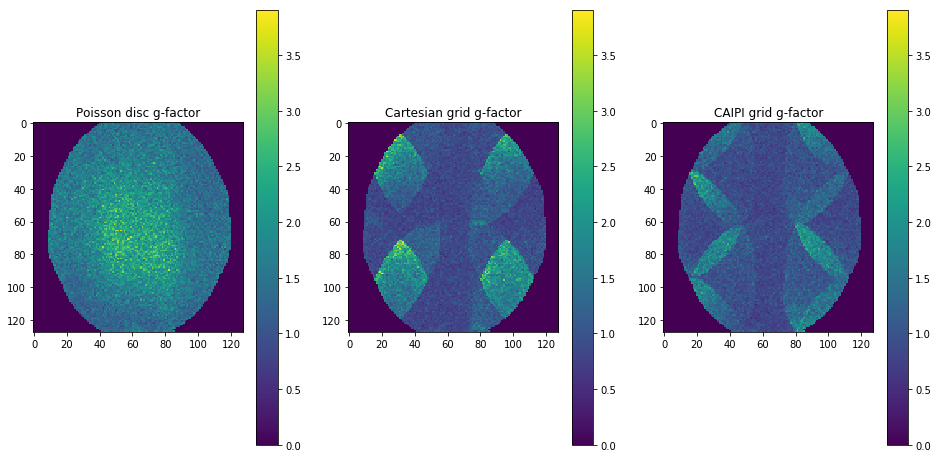

In [664]:
recon_noise_std = np.std(recons_noise, axis=2)
gfactor_cg = np.divide(np.std(recons_cg.real, axis=2), recon_noise_std, where=abs(recons_cg[:,:,0].squeeze()) != 0)
gfactor_pd = np.divide(np.std(recons_pd.real, axis=2), recon_noise_std, where=abs(recons_pd[:,:,0].squeeze()) != 0)
gfactor_ca = np.divide(np.std(recons_ca.real, axis=2), recon_noise_std, where=abs(recons_ca[:,:,0].squeeze()) != 0)


gfactor_cg /= np.sqrt(rx * ry)
gfactor_pd /= np.sqrt(rx * ry)
gfactor_ca /= np.sqrt(rx * ry)

max_gf_pd = np.max(gfactor_pd)
max_gf_cg = np.max(gfactor_cg)
max_gf_ca = np.max(gfactor_ca)

print('Max Poison disc g-factor value: {}'.format(max_gf_pd))
print('Max Cartesian Grid g-factor value: {}'.format(max_gf_cg))
print('Max CAIPI g-factor value: {}'.format(max_gf_ca))


plt.figure(figsize=(16, 8))
plt.subplot(1, 3, 1)
plt.imshow(gfactor_pd, vmax=np.max((max_gf_pd, max_gf_cg,max_gf_ca)))
plt.title('Poisson disc g-factor')
plt.colorbar()

plt.subplot(1, 3, 2)
plt.imshow(gfactor_cg, vmax=np.max((max_gf_pd, max_gf_cg,max_gf_ca)))
plt.title('Cartesian grid g-factor')
plt.colorbar()

plt.subplot(1, 3, 3)
plt.imshow(gfactor_ca, vmax=np.max((max_gf_pd, max_gf_cg,max_gf_ca)))
plt.title('CAIPI grid g-factor')
plt.colorbar()

In [420]:
g = np.histogram(gfactor_pd,np.arange(0,8,0.1))

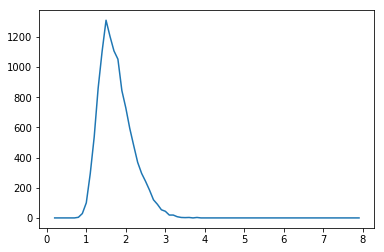

In [426]:
plt.plot(g[1][2:],g[0][1:])

In [502]:

x_pd=gfactor_pd.flatten()[np.where(gfactor_pd.flatten()>=0.1)[0]]
x_cg=gfactor_cg.flatten()[np.where(gfactor_cg.flatten()>=0.1)[0]]
x_ca=gfactor_ca.flatten()[np.where(gfactor_ca.flatten()>=0.1)[0]]

(0, 900)

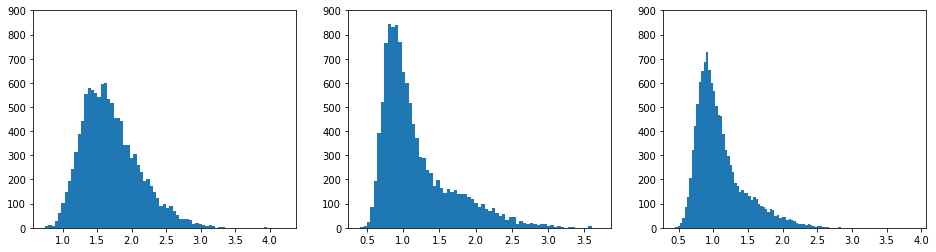

In [663]:
plt.figure(figsize=(16,4))
plt.subplot(1,3,1)
plt.ylim([0,900])
_=plt.hist(x_pd,bins='auto')
plt.subplot(1,3,2)
plt.ylim([0,900])
_=plt.hist(abs(x_cg),bins='auto')
plt.subplot(1,3,3)
_=plt.hist(abs(x_ca),bins='auto')
plt.ylim([0,900])

In [6]:
def read_matlab(filename):
    def conv(path=''):
        p = path or '/'
        paths[p] = ret = {}
        for k, v in f[p].items():
            if type(v).__name__ == 'Group':
                ret[k] = conv(f'{path}/{k}')  # Nested struct
                continue
            v = v[()]  # It's a Numpy array now
            if v.dtype == 'object':
                # HDF5ObjectReferences are converted into a list of actual pointers
                ret[k] = [r and paths.get(f[r].name, f[r].name) for r in v.flat]
            else:
                # Matrices and other numeric arrays
                ret[k] = v if v.ndim < 2 else v.swapaxes(-1, -2)
        return ret

    paths = {}
    with h5py.File(filename, 'r') as f:
        return conv()

In [88]:
np.argmin(sens.shape)

2

In [7]:
def swap(array,ind = 0):
    if ind == 0:
        nc, x, y = array.shape
        h_array = np.zeros((x,y,nc),dtype=complex)
        for i in range(nc):
            h_array[:,:,i] = np.copy(array[i])
    else:
        x, y, nc = array.shape
        h_array = np.zeros((nc,x,y),dtype=complex)
        for i in range(nc):
            h_array[i] = np.copy(array[:,:,i])
    return h_array

In [117]:
kswap = swap(raw,0)